In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp

import matplotlib.pyplot as plt
import seaborn as sn

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

gurobi_time_limit = 3600

In [2]:
stocks2019 = pd.read_csv("stocks2019.csv")
stocks2020 = pd.read_csv("stocks2020.csv")

In [3]:
print(stocks2019.shape)
print(stocks2020.shape)

(251, 102)
(252, 102)


# Preprocessing Stocks Data - 2019

In [4]:
## Changing the first column to datetime
stocks2019 = stocks2019.set_index(pd.to_datetime(stocks2019['X'])).drop(['X'], axis = 1)
stocks2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [5]:
## Creating an intermediate dataframe for processing
stocks2019_processed  = stocks2019

In [6]:
# Calculating the returns
def return_calc_function(x):
    return (x - x.shift(1))/x.shift(1) 
stocks2019_returns = stocks2019_processed.apply(return_calc_function, axis = 0)
## Since no return will be calculated for day 1, Row 0 will be empty 
## Dropping the NAN Rows
stocks2019_returns = stocks2019_returns.dropna(how = 'all')
print(stocks2019_returns.shape)
print(stocks2019_processed.shape)
stocks2019_returns.head()

## We can see that the first row has dropped
## Let's reset index so that we can use the general notation easily
stocks2019_returns = stocks2019_returns.reset_index().drop(['X'], axis = 1)
stocks2019_returns.head()

(250, 101)
(251, 101)


,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
1,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
3,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
4,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [7]:
## Calculating the similarity matrix
## Let's start by dropping the NDX from the dataset because, we dont need it in the 
## fund similarity
similarity = stocks2019_returns.drop(['NDX'], axis  =1).corr()
## The similarity matrix should be 100 X 100
print("The shape of similarity matirx is : {}".format(similarity.shape))
similarity.head()

The shape of similarity matirx is : (100, 100)


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934


In [8]:
similarity_array = similarity.to_numpy()

# Preprocessing 2020 Data 

In [9]:
stocks2020_processed = stocks2020.drop(stocks2020.columns[0], axis = 1)
stocks2020_returns = stocks2020_processed.apply(return_calc_function).dropna(how = 'all')
NDX_returns_2020 = stocks2020_returns.loc[:,['NDX']].to_numpy()
fund_returns_2020 = stocks2020_returns.drop(['NDX'], axis = 1)

# Let's start with Stock Selection 

In [10]:
def stock_selection(m):
    m = m
    cons_selection = len(similarity)
    obj = np.array([0]*cons_selection + list(similarity_array.flatten()))
    A = np.zeros((2*cons_selection+1 ,len(obj)))
    ## First constraint
    A[0][0:cons_selection]=1
    # ## next 100 constraint
    j=1
    for i in range(1,101):
        A[i][(j*cons_selection): ((j+1)*cons_selection)] = 1
        j=j+1

    # ## Last 100 constraints
    i = 0
    for constraint_number in range(101,201):
        A[constraint_number][i] = -100 ## - selection variable y
        for k in range(100):
            A[constraint_number][(k+1)*100 + i] = 1
        i = i+1
    
    ## RHS
    b = np.array([m]+[1]*cons_selection+[0]*cons_selection)
    ## Sense Array
    direction = np.array(['=']+ ['=']*cons_selection + ['<']*cons_selection)
    
    var_num = cons_selection + cons_selection*cons_selection

    tspMod = gp.Model()
    tspMod_x = tspMod.addMVar(var_num,vtype=['B']*var_num) 
    tspMod_con = tspMod.addMConstrs(A, tspMod_x, direction,b)
    tspMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    tspMod.Params.OutputFlag = 0
    tspMod.optimize()
    
    stocks_selected = list(similarity.columns[np.where(tspMod_x.x[0:cons_selection] == 1)])
    return stocks_selected

In [11]:
def weight_calculation(m,stocks_selected):
    ## Total variables = # time entries -1 (len return) & m variables for weights
    len_y_vars = len(stocks2019_returns) ## We have 250 timeperiods
    obj_wt = np.array([1]*len_y_vars + [0]*m) ## 250 Ys and m variables for weights
    #print(len(obj_wt))
    q = stocks2019_returns.loc[:,'NDX'].to_numpy()
    r_matrix = stocks2019_returns.loc[:,stocks_selected].to_numpy()
    ## Defining and filling up the constraint matrix
    A_weight = np.zeros((len_y_vars*2+1,len(obj_wt)))
    
    ## Greater than constraints
    A_weight[0:len_y_vars,0:len_y_vars] = np.identity(len_y_vars)
    A_weight[0:len_y_vars, len_y_vars:len_y_vars+m] = r_matrix

    ## Less than constraints
    A_weight[len_y_vars:len(A_weight)-1,0:len_y_vars] = np.identity(len_y_vars)
    A_weight[len_y_vars:len(A_weight)-1, len_y_vars:len_y_vars+m] = r_matrix*-1

    ## Weight Constraint
    A_weight[-1,len_y_vars:len_y_vars+m] = 1

    # ## RHS
    b_weight = np.append(np.append(q , -1*q),np.array([1]))

    ## Sense Aqrray
    direction_weight = np.array(['>']*len_y_vars*2 + ['=']*1)

    ## Optimization
    var_num = len(obj_wt)
    WeightMod = gp.Model()
    WeightMod_x = WeightMod.addMVar(var_num,vtype=['C']*var_num) 
    WeightMod_con = WeightMod.addMConstrs(A_weight, WeightMod_x, direction_weight,b_weight)
    WeightMod.setMObjective(None,obj_wt,0,sense=gp.GRB.MINIMIZE)

    WeightMod.Params.OutputFlag = 0 
    WeightMod.optimize()
    Index_Fund_Weights = WeightMod_x.x[-1*m:]

    return(Index_Fund_Weights)
    

In [12]:
def performanceEvaluation(returns_matrix, stocks_selected,Index_Fund_Weights):
    weighted_returns = np.array(returns_matrix.loc[:,stocks_selected]) * Index_Fund_Weights
    weighted_returns = weighted_returns.sum(axis = 1)
    ## Calculating the absolute deviations from the NASDAQ
    TotalAbsoluteDeviation = np.sum(np.abs(returns_matrix.iloc[:,0].to_numpy().flatten() - weighted_returns))
    return TotalAbsoluteDeviation

def weighted_returns(returns_matrix, stocks_selected,Index_Fund_Weights):
    weighted_returns = np.array(returns_matrix.loc[:,stocks_selected]) * Index_Fund_Weights
    weighted_returns = weighted_returns.sum(axis = 1)
    return weighted_returns

## Question-2 : Choosing 5 best stocks 

Academic license - for non-commercial use only - expires 2022-08-23
Using license file C:\Users\arora\gurobi.lic


Text(0.5, 0, 'Stocks Selected')

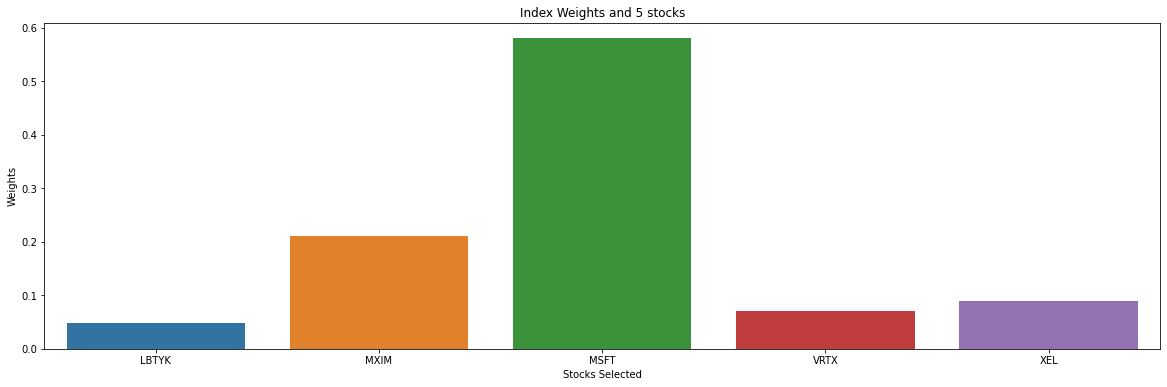

In [13]:
for i in [5]: 
    stocks_to_select = i
    a = stock_selection(stocks_to_select)
    Indexweights = weight_calculation(stocks_to_select,a)
plt.figure(figsize = (20,6))
plt.title("Index Weights and 5 stocks")
sn.barplot(x = a, y = Indexweights)
plt.ylabel("Weights")
plt.xlabel("Stocks Selected")

The five best stocks in order of weights are: MSFT, MXIM, XEL, VRTX, LBTYK

<AxesSubplot:title={'center':'Performance Evaluation on m=5'}, xlabel='Year', ylabel='Total Absolute Deviation'>

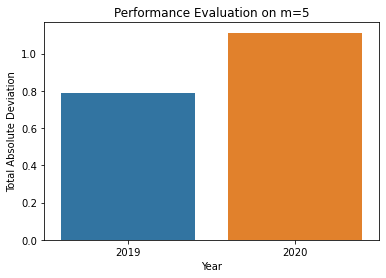

In [14]:
insample_perf = performanceEvaluation(stocks2019_returns,a,Indexweights)
outsample_perf = performanceEvaluation(stocks2020_returns,a,Indexweights)
plt.title("Performance Evaluation on m=5")
plt.xlabel("Year")
plt.ylabel("Total Absolute Deviation")
sn.barplot(x = [2019,2020], y = [insample_perf,outsample_perf])

In [15]:
print('Total absolute deviation from NASDAQ in 2019: ',round(insample_perf,3))
print('Total absolute deviation from NASDAQ in 2020: ',round(outsample_perf,3))

Total absolute deviation from NASDAQ in 2019:  0.789
Total absolute deviation from NASDAQ in 2020:  1.112


Based on the portfolio made using 2019 stocks data, in 2020, the total absolute deviation of the portfolio from NASDAQ is 0.323 units higher. This implies that the portofolio returns in 2020 are more widely dispersed from the actual value of the NASDAQ returns. This problem most likely arises because a portfolio of just 5 stocks is not large enough to accurately track the index fund. This idea is backed up the fact that even in 2019, the deviations from NASDAQ are relatively high. Therefore, increasing the number of stocks in the portfolio is more likely to closely mimic the returns of NASDAQ-100.

Text(0, 0.5, 'Returns')

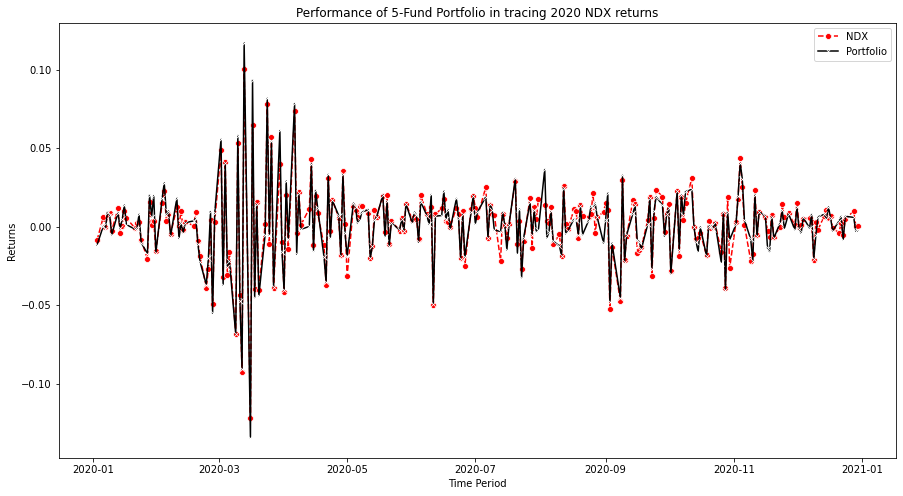

In [16]:
returns_timeline = pd.to_datetime(stocks2020.iloc[:,0])[1:]

plt.figure(figsize = (15,8))
sn.lineplot(x = returns_timeline, y = stocks2020_returns.loc[:,'NDX'], marker = 'o', 
            linestyle = 'dashed', color = 'red', label = 'NDX')
weighted_returns_5 = weighted_returns(stocks2020_returns,a,Indexweights)

sn.lineplot(x = returns_timeline, y = weighted_returns_5, marker = 'x',
             color = 'black', label = 'Portfolio')
plt.title("Performance of 5-Fund Portfolio in tracing 2020 NDX returns")
plt.xlabel('Time Period')
plt.ylabel('Returns')

From the above graph, we can see that the portoflio is relatively accurate in tracking the index fund in 2020. Especially when there are large fluctuations in the returns. For example, between the time periods 2020-03 and 2020-05. The biggest discrepancies are seen at 2020-5, between 2020-07 and 2020-08, and finally near 2020-11, when the black line (portfolio) is clearly not overlapping with the red line (NDX).

Text(0, 0.5, 'Total Absolute Deviation')

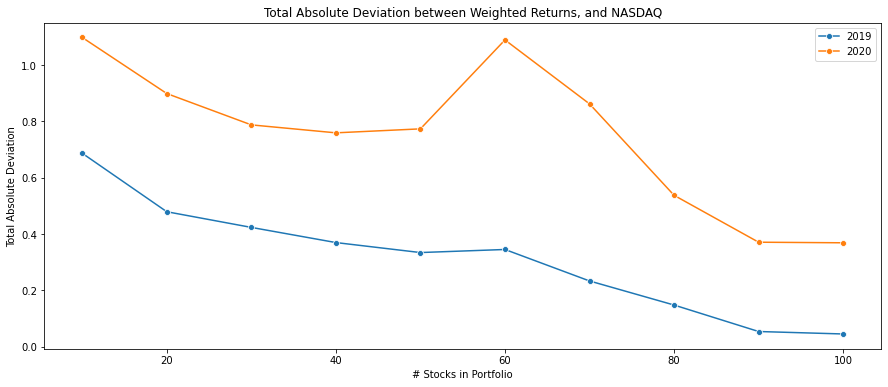

In [17]:
perf_2019 = []
perf_2020 = []
for i in range(10,110,10): 
    stocks_to_select = i
    a = stock_selection(stocks_to_select)
    Indexweights = weight_calculation(stocks_to_select,a)
    perf_2020.append(performanceEvaluation(stocks2020_returns,a,Indexweights))
    perf_2019.append(performanceEvaluation(stocks2019_returns,a,Indexweights))
plt.figure(figsize = (15,6))
sn.lineplot(x = range(10,110,10), y= perf_2019, label = "2019", marker = "o")
sn.lineplot(x = range(10,110,10), y= perf_2020, label = "2020", marker = "o" )
plt.title("Total Absolute Deviation between Weighted Returns, and NASDAQ")
plt.xlabel("# Stocks in Portfolio")
plt.ylabel("Total Absolute Deviation")

<AxesSubplot:>

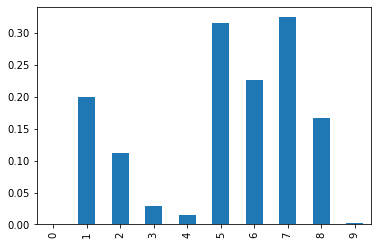

In [18]:
pd.Series(pd.Series(perf_2020) - pd.Series(perf_2020).shift(1)).apply(lambda x : np.abs(x)).plot(kind = 'bar')

We can see that, for both 2019 and 2020, the total absolute deviation is consistently decreasing till 50 stocks in the portfolio. This is exactly what we expected when we were evalutaing results for the 5 stock portfolio.

At 60 stocks in the portfolio, we see diminishing returns starting to set in as a result of adding more stocks to the portfolio. This change is much more evident in the 2020 graph. This is because the modeling was done using weights from 2019. 

After 60 stocks, the deviation from the index fund starts to decrease again, and finaly gets stable in 2020 at number of stocks in portfolio equal to 90 and 100. Therefore, 90 stocks is optimal for the portfolio as that has the least deviation from the index fund.

# Q-4 

In [19]:
stocks2019_returns

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
1,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
3,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
4,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.002019,-0.005572,0.004090,0.029672,0.006469,0.019239,-0.000437,-0.000556,0.003638,-0.000123,...,0.002603,0.010060,-0.000104,-0.000869,-0.003217,0.003083,-0.009273,0.026019,-0.017615,0.011868
246,0.000402,-0.001358,0.002098,0.023757,-0.001630,-0.000899,-0.004590,-0.003914,-0.002114,-0.002880,...,-0.005482,-0.002095,0.001663,-0.002541,0.002637,-0.003756,0.003502,-0.007496,0.003913,-0.004146
247,0.009058,0.001360,0.004732,0.001934,-0.012242,0.001331,0.013418,0.012534,0.044467,-0.001774,...,0.002901,-0.004594,0.004981,-0.002279,-0.001406,0.009426,-0.004994,0.009160,-0.001114,0.001929
248,-0.000835,0.005094,-0.001238,-0.009650,-0.003488,-0.002228,-0.005747,-0.006256,0.000551,-0.001530,...,0.001157,0.007321,0.001755,-0.001680,0.003269,0.002037,0.002963,-0.010669,0.005256,-0.002635


# Question 4 

In [26]:
len_y_vars = len(stocks2019_returns) ## We have 250 timeperiods
weight_variables = stocks2019_returns.shape[1]-1
stock_selector_binary_var = stocks2019_returns.shape[1]-1
obj_wt = np.array([1]*len_y_vars + [0]*weight_variables+ [0]*stock_selector_binary_var ) 
stock_returns_2019_all_funds = stocks2019_returns.drop(['NDX'], axis = 1).to_numpy()
obj_wt.shape

q = stocks2019_returns.loc[:,'NDX'].to_numpy()
M = 1
A_weight = np.zeros((2*len_y_vars + weight_variables+2 ,len(obj_wt)))
A_weight.shape

(602, 450)

In [25]:
def MIP_Solver(m_input):
    len_y_vars = len(stocks2019_returns) ## We have 250 timeperiods
    weight_variables = stocks2019_returns.shape[1]-1
    stock_selector_binary_var = stocks2019_returns.shape[1]-1
    obj_wt = np.array([1]*len_y_vars + [0]*weight_variables+ 
                      [0]*stock_selector_binary_var ) 
    stock_returns_2019_all_funds = stocks2019_returns.drop(['NDX'], axis = 1).to_numpy()
    
    q = stocks2019_returns.loc[:,'NDX'].to_numpy()
    M = 1
    A_weight = np.zeros((2*len_y_vars + weight_variables+2 ,len(obj_wt)))
    ## First 250 constraints
    A_weight[0:len_y_vars,0:len_y_vars] = np.identity(len_y_vars)
    A_weight[0:len_y_vars,len_y_vars:len_y_vars+weight_variables] = stock_returns_2019_all_funds
    ## Next 250 constraints
    A_weight[len_y_vars:2*len_y_vars,0:len_y_vars] = np.identity(len_y_vars)
    A_weight[len_y_vars:2*len_y_vars,len_y_vars:len_y_vars+weight_variables] = stock_returns_2019_all_funds*-1
    ## Next 100 constraints
    ## For Big M Constraints
    i = 0
    for row_number in range(2*len_y_vars, 2*len_y_vars+weight_variables):
        A_weight[row_number][len_y_vars+i]=1
        A_weight[row_number][len_y_vars+weight_variables+i]=-1*M
        i = i+1

    ## Last 1 constraint to make sure that indicator variables add up to #stocks to pick
    A_weight[-2][-1*stock_selector_binary_var:] = 1
    
    ## Last 1 constraint to make the weights as 1
    A_weight[-1][len_y_vars: len_y_vars+weight_variables] = 1
    
    
    m = m_input
    b_weight = np.array(list(q) + list(-1*q) + [0]*weight_variables + [m]*1 +[1]*1)
    ## Sense Aqrray
    direction_weight = np.array(['>']*len_y_vars*2 + ['<']*weight_variables +['=']*2)
        
    ## Optimization
    var_num = len(obj_wt)
    WeightMod = gp.Model()
    WeightMod_x = WeightMod.addMVar(var_num,vtype=['C']*len_y_vars + ['C']*weight_variables +['B']*stock_selector_binary_var) 
    WeightMod_con = WeightMod.addMConstrs(A_weight, WeightMod_x, direction_weight,b_weight)
    WeightMod.setMObjective(None,obj_wt,0,sense=gp.GRB.MINIMIZE)
    WeightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    WeightMod.Params.timeLimit = gurobi_time_limit
    WeightMod.optimize()
    
    return WeightMod_x.x[len_y_vars: len_y_vars+weight_variables]


Text(0, 0.5, 'Total Absolute Deviation')

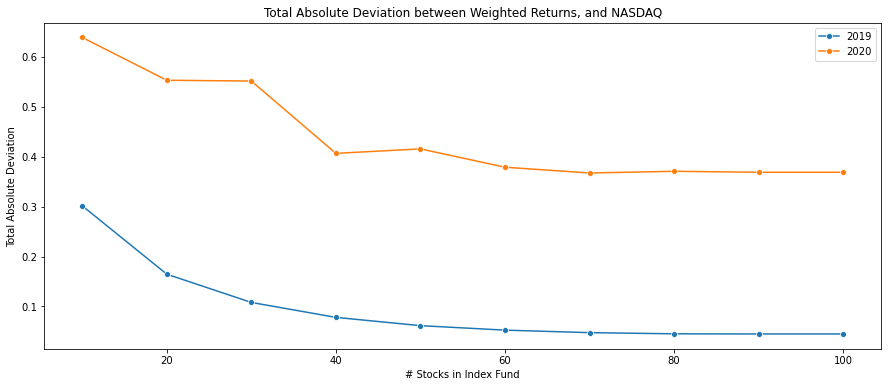

In [26]:
perf_2019_method2 = []
perf_2020_method2 = []
for i in range(10,110,10): 
    stocks_to_select = stocks2019_returns.columns[1:]
    Indexweights = MIP_Solver(i)
    perf_2020_method2.append(performanceEvaluation(stocks2020_returns,stocks_to_select,Indexweights))
    perf_2019_method2.append(performanceEvaluation(stocks2019_returns,stocks_to_select,Indexweights))

pd.DataFrame(perf_2020_method2).to_csv("2020.csv")
pd.DataFrame(perf_2019_method2).to_csv("2019.csv")

    
plt.figure(figsize = (15,6))
sn.lineplot(x = range(10,110,10), y= perf_2019_method2, label = "2019", marker = "o")
sn.lineplot(x = range(10,110,10), y= perf_2020_method2, label = "2020", marker = "o" )
plt.title("Total Absolute Deviation between Weighted Returns, and NASDAQ")
plt.xlabel("# Stocks in Index Fund")
plt.ylabel("Total Absolute Deviation")

From the above graph, it is evident that the second method is much more accurate in tracking NASDAQ. Even at 5 stocks in the portfolio, the deviation in 2020 is near 0.65, whereas in the old method, it was over 1.

We can also see that there are no diminishing returns at any point in the graph. In fact, the graph starts to get stable earlier at 60 stocks in the portfolio (both in 2019 and 2020). The final value of the deviation in 2020 is very similar to the value of deviation obtained in the old method, but the optimal number of stocks is much lesser. In this method, the optimal stocks is 70 (becuase deviation at 60 is slightly higher).